In [322]:
# импорт библиотек

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pyarrow.parquet as pq
import gc
import seaborn as sns
from tqdm.notebook import tqdm
from catboost import CatBoostClassifier
from catboost.utils import eval_metric
from catboost import cv
from catboost import Pool
from sklearn.model_selection import train_test_split
from random import sample
from sklearn.neighbors import NearestNeighbors
from numpy import random
%matplotlib inline
plt.style.use('seaborn')

C:\Users\l-pla\AppData\Local\Temp\ipykernel_3656\474374634.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Загрузка данных

In [73]:
# загрузка данных y_train

y_train = pq.ParquetFile('C:\\Hackathon\\train\\y_train.parquet')
y_train = y_train.read_row_group(0)

df = []
for col in y_train.column_names:
    if col == 'DT':
        df.append(y_train[col].to_pandas()) 
    else:
        df.append(y_train[col].to_pandas().astype('int8'))

target_df = pd.concat(df, axis=1)

del y_train
del df
del col
gc.collect()

21383555

In [74]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9335034 entries, 0 to 9335033
Columns: 176 entries, DT to Y_ЭКСГАУСТЕР А/М №6_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№6 Т.2
dtypes: datetime64[ns](1), int8(175)
memory usage: 1.6 GB


In [75]:
# загрузка данных X_train

X_train = pq.ParquetFile('C:\\Hackathon\\train\\X_train.parquet')
X_train = X_train.read_row_group(0)

df = []
for col in X_train.column_names:
    if col == 'DT':
        df.append(X_train[col].to_pandas()) 
    else:
        df.append(X_train[col].to_pandas().astype("float32"))

train_df = pd.concat(df, axis=1)

del X_train
del df
del col
gc.collect()

96534

In [76]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9335034 entries, 0 to 9335033
Data columns (total 97 columns):
 #   Column                                           Dtype         
---  ------                                           -----         
 0   DT                                               datetime64[ns]
 1   ЭКСГАУСТЕР 4. ТОК РОТОРА 1                       float32       
 2   ЭКСГАУСТЕР 4. ТОК РОТОРА2                        float32       
 3   ЭКСГАУСТЕР 4. ТОК СТАТОРА                        float32       
 4   ЭКСГАУСТЕР 4. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ           float32       
 5   ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1  float32       
 6   ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2  float32       
 7   ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3  float32       
 8   ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4  float32       
 9   ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ        float32       
 10  ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ     float

In [77]:
# Установим время в качестве индекса
target_data = target_df.copy().set_index('DT')
train_data = train_df.copy().set_index('DT')

# Возьмем отсчеты каждые 30 секунд
target_data = target_data.iloc[::3,::]
train_data = train_data.iloc[::3,::]

In [78]:
print(target_data.shape)
print(train_data.shape)

(3111678, 175)
(3111678, 96)


In [79]:
# Загрузка messages

messages = pd.read_excel('C:\\Hackathon\\Defect detection\\data\\train\\messages.xlsx')

### Строим классификацию по принципу OneVsAll 

Для этого сформируем два датасета и обучим два классификатора 

#### Формирование датасета для классификации М1 ошибки

In [80]:
def bar_plots_target (target_df):

    """Функция построения столючатой диаграммы распределения видов по типам неисправностей

    Args:
        target_df (DataFrame): таргет датафрейм
    """
    try:
        defect_name_list = list(target_df.columns) # Список определяемых дефектов
    
        # Построение диаграмм
        fig, ax = plt.subplots(ncols=3, nrows=round(len(defect_name_list)/3), figsize=(25,len(defect_name_list)))
        for i,j in zip(range(round(len(defect_name_list)/3)), range(0,len(defect_name_list),3)):
            bar_data = target_df.iloc[:,j].value_counts().reset_index()
            sns.barplot(data=bar_data, x=bar_data['index'], y=bar_data.iloc[:,1], ax=ax[i][0]).set(xlabel='defect_type 1 - M1, 2 - M3', ylabel='count', title=defect_name_list[j])
            del bar_data

            bar_data = target_df.iloc[:,j+1].value_counts().reset_index()
            sns.barplot(data=bar_data, x=bar_data['index'], y=bar_data.iloc[:,1], ax=ax[i][1]).set(xlabel='defect_type 1 - M1, 2 - M3', ylabel='count', title=defect_name_list[j+1])
            del bar_data

            bar_data = target_df.iloc[:,j+2].value_counts().reset_index()
            sns.barplot(data=bar_data, x=bar_data['index'], y=bar_data.iloc[:,1], ax=ax[i][2]).set(xlabel='defect_type 1 - M1, 2 - M3', ylabel='count', title=defect_name_list[j+2])
            del bar_data

        plt.tight_layout()
        plt.show()
    except IndexError: 
        print('Количество ячеек больше количества графиков')

In [81]:
# Заменить все 2 (М3) на 0 
target_data = target_data.replace(2, 0)

In [ ]:
# Построим столбчатые диаграммы распределения видов и типов неисправностей 
#bar_plots_target(target_data)

In [82]:
# Удалим лишние столбцы из messages
messages.drop(columns = ['Unnamed: 0', 'ТЕКСТ_ГРУППЫ_КОДОВ'], inplace = True)


# Создадим новый призкак "Время ремонта" в секундах
messages['Время ремонта'] = (messages['ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ'] - messages['ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ'])
messages['Время ремонта'] = messages['Время ремонта'].dt.total_seconds()

In [83]:
# Выберем из messages сообщения об М1
messages_M1 = messages[messages['ВИД_СООБЩЕНИЯ'] == 'M1']

In [84]:
target_data = target_data.reset_index()

In [87]:
# Сформируем таргет датасет в котором будут содержаться отметки с М1

target_data_M1 = pd.DataFrame()
for i in tqdm(range(len(messages_M1))):
    filt_1 = (target_data['DT'] <= messages_M1.iloc[i,7].floor('10S') + pd.to_timedelta('10 sec'))
    filt_2 = (target_data['DT'] >= (messages_M1.iloc[i, 6].floor('10S')+ pd.to_timedelta('10 sec')) - pd.to_timedelta('3 hour'))
    target_data_M1 = target_data_M1.append(target_data[filt_1 & filt_2])

del filt_1
del filt_2

  0%|          | 0/83 [00:00<?, ?it/s]

C:\Users\l-pla\AppData\Local\Temp\ipykernel_3656\2504545370.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_data_M1 = target_data_M1.append(target_data[filt_1 & filt_2])
C:\Users\l-pla\AppData\Local\Temp\ipykernel_3656\2504545370.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_data_M1 = target_data_M1.append(target_data[filt_1 & filt_2])
C:\Users\l-pla\AppData\Local\Temp\ipykernel_3656\2504545370.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_data_M1 = target_data_M1.append(target_data[filt_1 & filt_2])
C:\Users\l-pla\AppData\Local\Temp\ipykernel_3656\2504545370.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

In [88]:
target_data_M1 = target_data_M1.drop_duplicates()
target_data_M1.shape

(41265, 176)

In [93]:
# Установим DT как индекс
target_data_M1 = target_data_M1.set_index('DT')

In [94]:
def del_col_with_only_zero (df):
    """ Удалим таргеты, состоящиет только из нулей

    Args:
        df (pd.DataFrame()): таргейт датафрейм
        
    return:
        df (pd.DataFrame()): таргет датафрейм без таргетов, состоящих только из нулей
    """
    drop_col_list = []
    for col in df.columns.tolist():
        if (sum(df[col].value_counts().index) == 0):
            drop_col_list.append(col)

    df.drop(columns = drop_col_list, axis = 1, inplace = True)
    return df

In [95]:
# Удалим в таргете некоторые столбцы 
target_data_M1 = del_col_with_only_zero(target_data_M1)
target_data_M1.shape

(41265, 34)

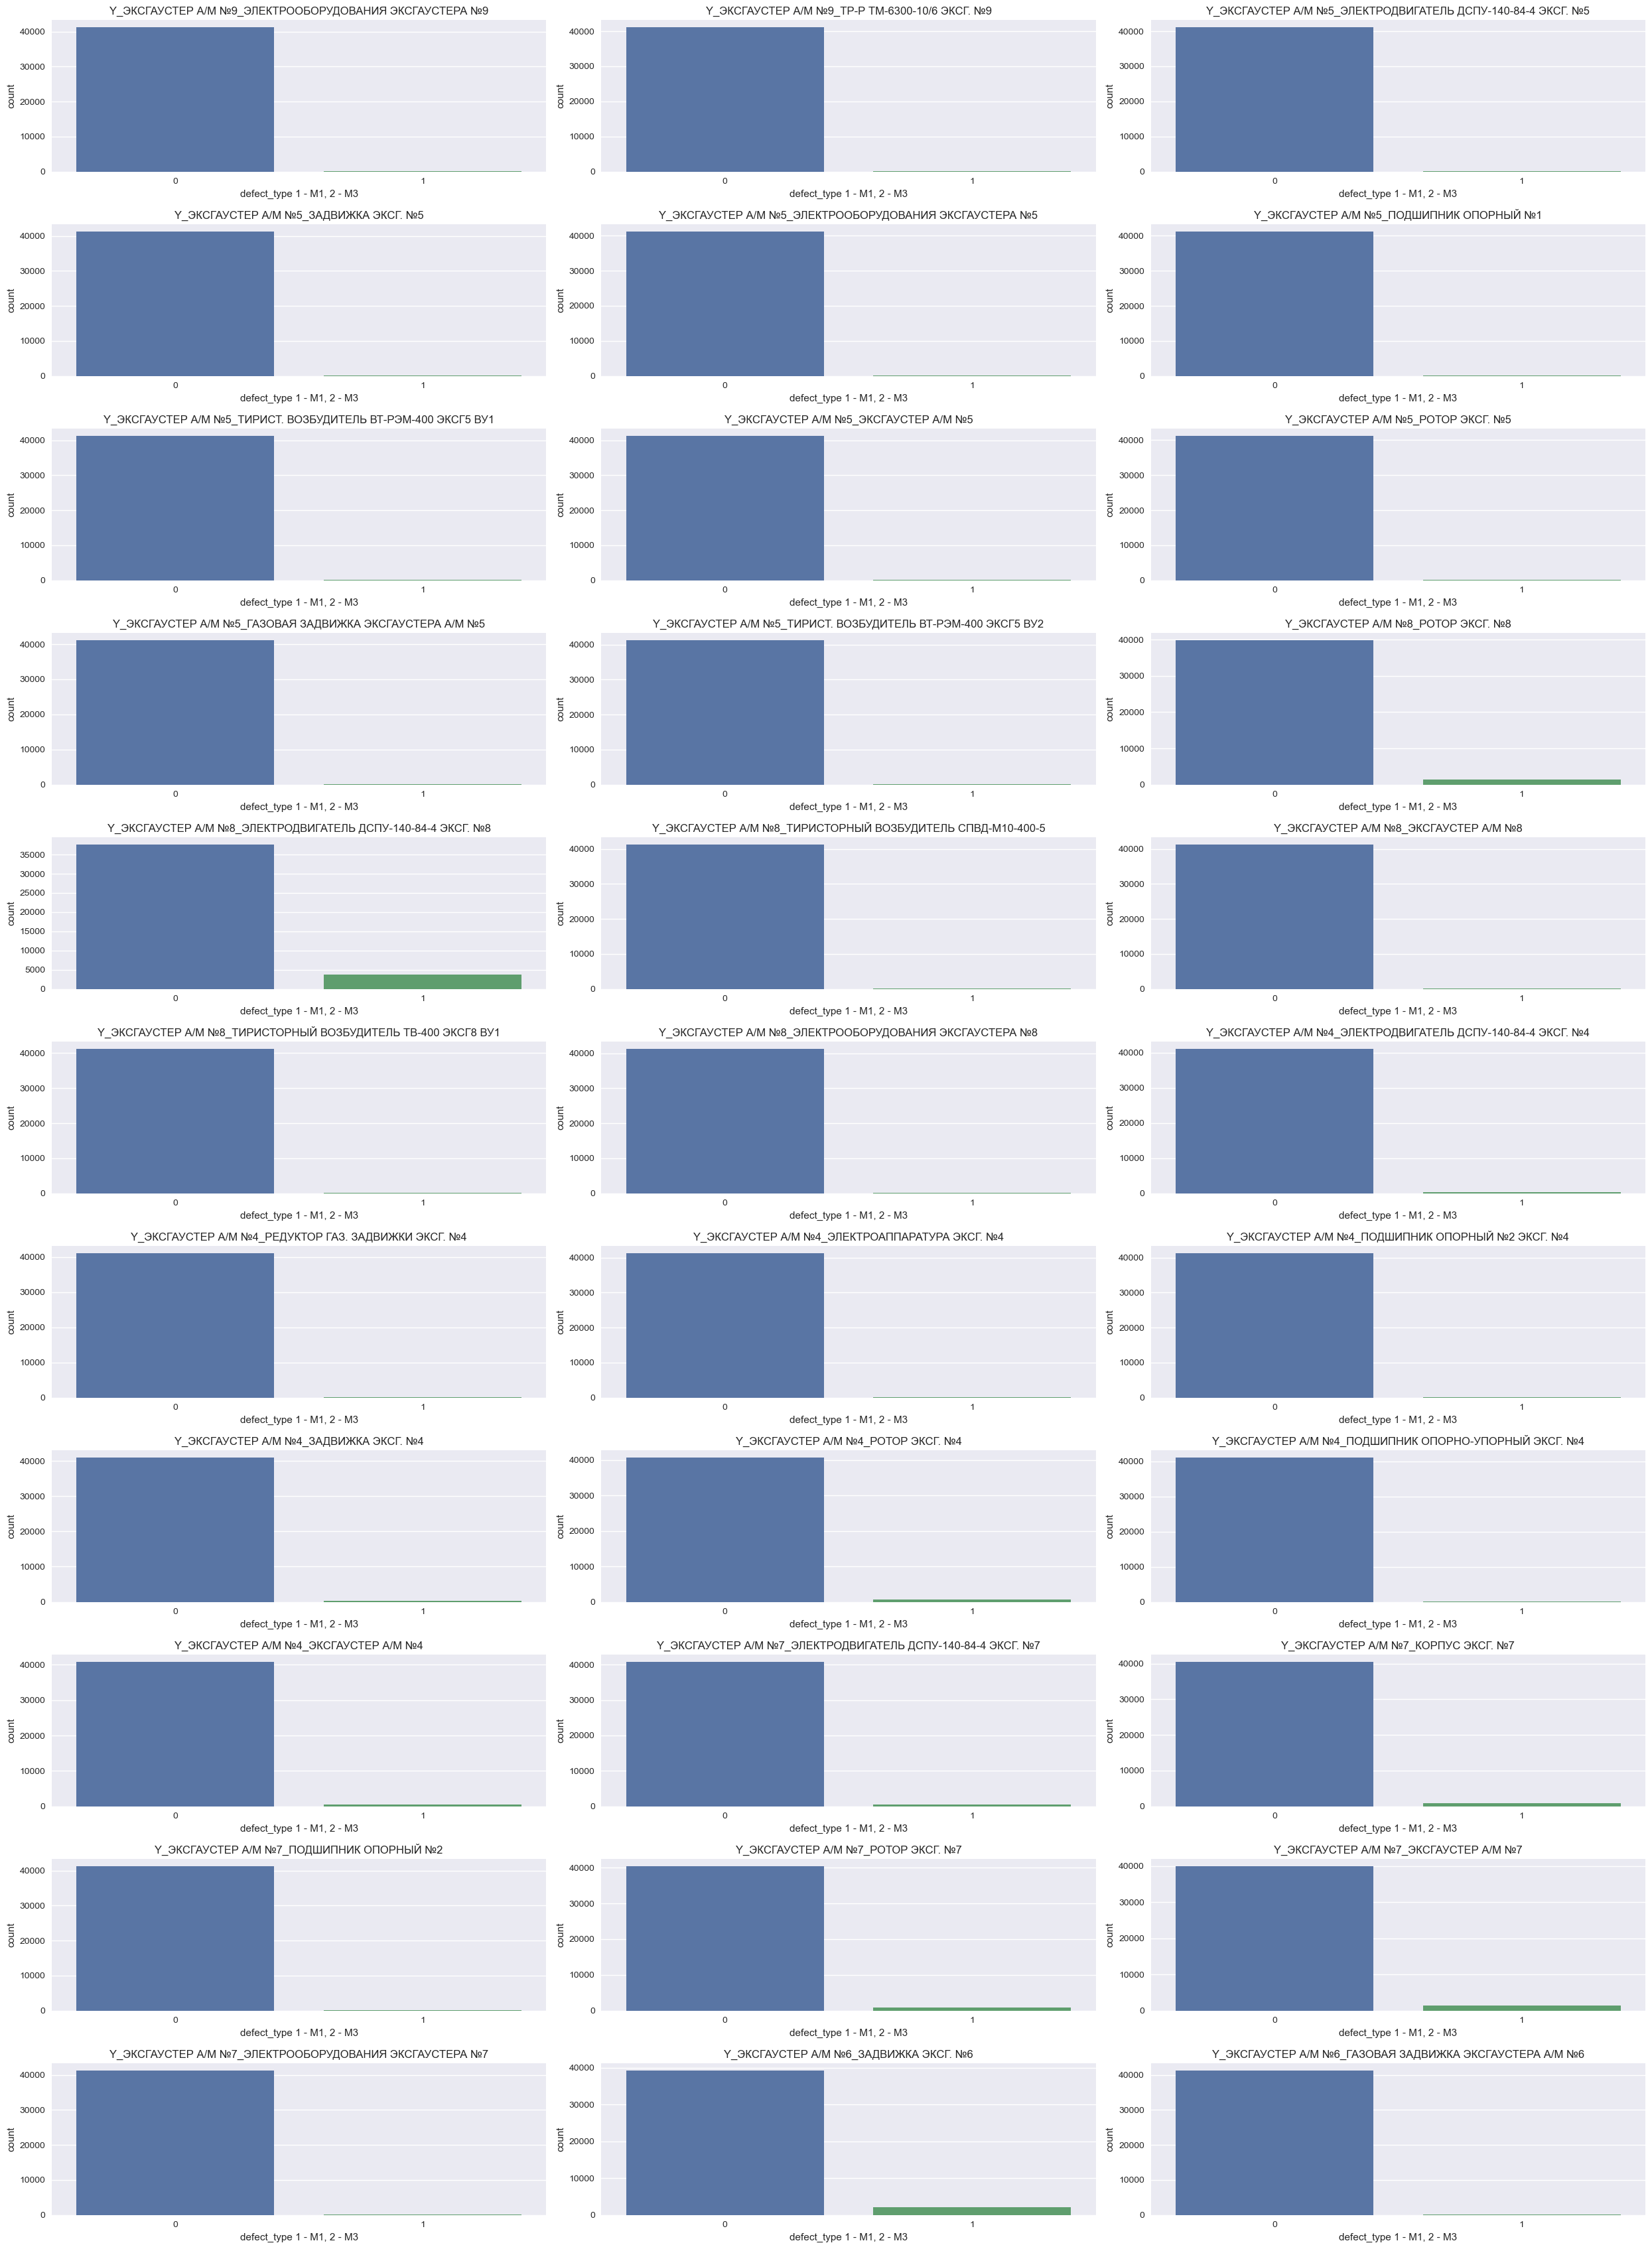

In [96]:
bar_plots_target(target_data_M1)

In [97]:
# Сбросим индексы
train_data = train_data.reset_index()
target_data_M1 = target_data_M1.reset_index()

In [98]:
# Объединим в один датафрейм по времени
dataset = train_data.merge(target_data_M1, how = 'inner', on = 'DT')
dataset.shape

(41265, 131)

In [100]:
# Разедлим датасет на трейн и таргет
train = dataset.iloc[::,1:97]
target = dataset.iloc[::,97:]

#del dataset
#del train_data
#del target_data

In [101]:
# Переведем таргет в category
for col in target.columns:
    target[col] = target[col].astype('category')

In [194]:
# Раздели выборки на трейн, тест и валидацию
X_train, X_validation, y_train, y_validation = train_test_split(train, target, train_size = 0.8, random_state = 45)
X_train, X_test, y_train, y_test = train_test_split(train, target, train_size = 0.8, random_state = 42)

#del train
#del target
#del target_df
#del train_df

#### Обработка трейна

Пропуски

In [196]:
# Количество пропусков в трейне
X_train.isna().sum().sum()

520781

In [197]:
# Обработаем пропуски, заполнив их следующим или предыдущим значением
X_train = X_train.fillna(method='ffill').fillna(method='bfill')


In [198]:
# Количество пропусков в трейне
X_train.isna().sum().sum()

0

Мультикорреляция

In [199]:
def list_multicorr_features (features_data):
    
    """Возвращает список мультикоррелированных фичей
    Args:
        features_data (DataFrame): Датафрейм
    """
    # находим корреляционную матрицу
    corr_matrix = features_data.corr().abs()

    # создаем маску для отбора признаков с корреляцией >0.95
    mask = (corr_matrix > 0.95)

    # находим список признаков с корреляцией > 0.95
    return corr_matrix.columns[mask.any()].tolist()

In [200]:
multi_corr_feature_4 = list_multicorr_features(X_train.filter(like = 'ЭКСГАУСТЕР 4'))
print(multi_corr_feature_4)

multi_corr_feature_5 = list_multicorr_features(X_train.filter(like = 'ЭКСГАУСТЕР 5'))
print(multi_corr_feature_5)

multi_corr_feature_6 = list_multicorr_features(X_train.filter(like = 'ЭКСГАУСТЕР 6'))
print(multi_corr_feature_6)

multi_corr_feature_7 = list_multicorr_features(X_train.filter(like = 'ЭКСГАУСТЕР 7'))
print(multi_corr_feature_7)

multi_corr_feature_8 = list_multicorr_features(X_train.filter(like = 'ЭКСГАУСТЕР 8'))
print(multi_corr_feature_8)

multi_corr_feature_9 = list_multicorr_features(X_train.filter(like = 'ЭКСГАУСТЕР 9'))
print(multi_corr_feature_9)


['ЭКСГАУСТЕР 4. ТОК РОТОРА 1', 'ЭКСГАУСТЕР 4. ТОК РОТОРА2', 'ЭКСГАУСТЕР 4. ТОК СТАТОРА', 'ЭКСГАУСТЕР 4. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ', 'ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1', 'ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2', 'ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3', 'ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4', 'ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ', 'ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ', 'ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 1', 'ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 2', 'ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 3', 'ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.', 'ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 4', 'ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.']
['ЭКСГАУСТЕР 5. ТОК РОТОРА 1', 'ЭКСГАУСТЕР 5. ТОК РОТОРА 2', 'ЭКСГАУСТЕР 5. ТОК СТАТОРА', 'ЭКСГАУСТЕР 5. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ', 'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1', 'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2', 'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3', 'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА Н

In [201]:
# Выберем фичи для удаления
multi_corr_feature_4 = ['ЭКСГАУСТЕР 4. ТОК РОТОРА2',
                        'ЭКСГАУСТЕР 4. ТОК СТАТОРА', 
                        'ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2', 
                        'ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3', 
                        'ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4',
                        'ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ', 
                         'ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 2', 
                         'ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 3', 
                         'ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.', 
                         'ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 4', 
                         'ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.'
                        
]

multi_corr_feature_5 = ['ЭКСГАУСТЕР 5. ТОК РОТОРА 2',
                        'ЭКСГАУСТЕР 5. ТОК СТАТОРА', 
                        'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2', 
                        'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3', 
                        'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4',
                        'ЭКСГАУСТЕР 5. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ', 
                         'ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 2', 
                         'ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 3', 
                         'ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.', 
                         'ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 4', 
                         'ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.'
                        
]

multi_corr_feature_6 = ['ЭКСГАУСТЕР 6. ТОК РОТОРА 2',
                        'ЭКСГАУСТЕР 6. ТОК СТАТОРА', 
                        'ЭКСГАУСТЕР 6. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2', 
                        'ЭКСГАУСТЕР 6. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3', 
                        'ЭКСГАУСТЕР 6. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4',
                        'ЭКСГАУСТЕР 6. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ', 
                         'ЭКСГАУСТЕР 6. ВИБРАЦИЯ НА ОПОРЕ 2', 
                         'ЭКСГАУСТЕР 6. ВИБРАЦИЯ НА ОПОРЕ 3', 
                         'ЭКСГАУСТЕР 6. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.', 
                         'ЭКСГАУСТЕР 6. ВИБРАЦИЯ НА ОПОРЕ 4', 
                         'ЭКСГАУСТЕР 6. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.'
                        
]

multi_corr_feature_7 = ['ЭКСГАУСТЕР 7. ТОК РОТОРА 2',
                        'ЭКСГАУСТЕР 7. ТОК СТАТОРА', 
                        'ЭКСГАУСТЕР 7. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2', 
                        'ЭКСГАУСТЕР 7. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3', 
                        'ЭКСГАУСТЕР 7. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4',
                        'ЭКСГАУСТЕР 7. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ', 
                         'ЭКСГАУСТЕР 7. ВИБРАЦИЯ НА ОПОРЕ 2', 
                         'ЭКСГАУСТЕР 7. ВИБРАЦИЯ НА ОПОРЕ 3', 
                         'ЭКСГАУСТЕР 7. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.', 
                         'ЭКСГАУСТЕР 7. ВИБРАЦИЯ НА ОПОРЕ 4', 
                         'ЭКСГАУСТЕР 7. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.'
                        
]

multi_corr_feature_8 = ['ЭКСГАУСТЕР 8. ТОК РОТОРА 2',
                        'ЭКСГАУСТЕР 8. ТОК СТАТОРА', 
                        'ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2', 
                        'ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3', 
                        'ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4',
                        'ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ', 
                         'ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 2', 
                         'ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 3', 
                         'ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.', 
                         'ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 4', 
                         'ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.'
                        
]

multi_corr_feature_9 = ['ЭКСГАУСТЕР 9. ТОК РОТОРА 2',
                        'ЭКСГАУСТЕР 9. ТОК СТАТОРА', 
                        'ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2', 
                        'ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3', 
                        'ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4',
                        'ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ', 
                         'ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 2', 
                         'ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 3', 
                         'ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.', 
                         'ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 4', 
                         'ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.'
                        
]

In [202]:
# Удалим из трейна
X_train.drop(columns = multi_corr_feature_4, axis = 1, inplace = True)
X_train.drop(columns = multi_corr_feature_5, axis = 1, inplace = True)
X_train.drop(columns = multi_corr_feature_6, axis = 1, inplace = True)
X_train.drop(columns = multi_corr_feature_7, axis = 1, inplace = True)
X_train.drop(columns = multi_corr_feature_8, axis = 1, inplace = True)
X_train.drop(columns = multi_corr_feature_9, axis = 1, inplace = True)

In [203]:
# Удалим из валидационного множества
X_validation.drop(columns = multi_corr_feature_4, axis = 1, inplace = True)
X_validation.drop(columns = multi_corr_feature_5, axis = 1, inplace = True)
X_validation.drop(columns = multi_corr_feature_6, axis = 1, inplace = True)
X_validation.drop(columns = multi_corr_feature_7, axis = 1, inplace = True)
X_validation.drop(columns = multi_corr_feature_8, axis = 1, inplace = True)
X_validation.drop(columns = multi_corr_feature_9, axis = 1, inplace = True)

In [204]:
X_train.shape

(33012, 30)

In [205]:
X_validation.shape

(8253, 30)

### Построение модели

In [211]:
model_defect_M1 = CatBoostClassifier(
    iterations=12000,
    learning_rate=0.02,
    random_seed=42,
    save_snapshot = True,
    snapshot_file = 'model_defect_1_1.bkp',
    snapshot_interval = 60,
    l2_leaf_reg = 3,
    bagging_temperature = 1,
    random_strength = 1,
    leaf_estimation_method = 'Newton',
    loss_function = 'MultiLogloss',
    custom_metric = 'F1',
    early_stopping_rounds = 20     
)




model_defect_M1.fit(
    X_train,
    y_train,
    verbose = True,
    use_best_model = True,
    eval_set = (X_validation, y_validation)
)

0:	learn: 0.6269166	test: 0.6264055	best: 0.6264055 (0)	total: 302ms	remaining: 1h 20s
1:	learn: 0.5704686	test: 0.5702084	best: 0.5702084 (1)	total: 630ms	remaining: 1h 2m 57s
2:	learn: 0.5175644	test: 0.5167558	best: 0.5167558 (2)	total: 1.03s	remaining: 1h 8m 59s
3:	learn: 0.4691061	test: 0.4681144	best: 0.4681144 (3)	total: 1.37s	remaining: 1h 8m 29s
4:	learn: 0.4270207	test: 0.4260968	best: 0.4260968 (4)	total: 1.69s	remaining: 1h 7m 40s
5:	learn: 0.3879923	test: 0.3870193	best: 0.3870193 (5)	total: 2.02s	remaining: 1h 7m 12s
6:	learn: 0.3524327	test: 0.3515163	best: 0.3515163 (6)	total: 2.33s	remaining: 1h 6m 40s
7:	learn: 0.3208027	test: 0.3202497	best: 0.3202497 (7)	total: 2.66s	remaining: 1h 6m 22s
8:	learn: 0.2922237	test: 0.2945144	best: 0.2945144 (8)	total: 2.98s	remaining: 1h 6m 11s
9:	learn: 0.2665656	test: 0.2710920	best: 0.2710920 (9)	total: 3.3s	remaining: 1h 5m 57s
10:	learn: 0.2442846	test: 0.2503469	best: 0.2503469 (10)	total: 3.62s	remaining: 1h 5m 46s
11:	learn: 0

In [ ]:
model_defect_M1.get_feature_importance(prettified = True)

In [319]:
y_pred = model_defect_M1.predict(X_test)

In [232]:
#Сохранение модели
#model_defect_M1.save_model('model_detect_defect_m1_1.bin')
#model_defect_M1.save_model('model_detect_defect_m1_1.json', format = 'json')


In [317]:
# 'Precision'
precision_dict = {}
values = eval_metric(y_test.values, y_pred, 'Precision')
for cls, value in zip(model_defect_M1.classes_, values):
    precision_dict[cls] = value

#'Recall'
recall_dict = {}
values = eval_metric(y_test.values, y_pred, 'Recall')
for cls, value in zip(model_defect_M1.classes_, values):
    recall_dict[cls] = value

#'F1'
f1_dict = {}
values = eval_metric(y_test.values, y_pred, 'F1')
for cls, value in zip(model_defect_M1.classes_, values):
    f1_dict[cls] = value


# Посчитаем среднее значение метрик по всем таргетам
print(f'Среднее значение метрики Precision -  {np.mean(list(precision_dict.values()))}')
print(f'Среднее значение метрики Recall -  {np.mean(list(recall_dict.values()))}')
print(f'Среднее значение метрики F1 -  {np.mean(list(f1_dict.values()))}')

Среднее значение метрики Precision -  0.9273313757720834
Среднее значение метрики Recall -  0.6893483556129165
Среднее значение метрики F1 -  0.7250415397851921


In [266]:
print(metrics.classification_report(list(y_test.values[6]), y_pred[6]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00         1

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34



### Подбор гиперпараметров

In [371]:
import optuna

In [384]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    iterations = trial.suggest_int('iterations', 1000, 2000, step=100)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, step=0.01)
    max_depth = trial.suggest_int('max_depth', 4, 10, step=1)
    leaf_estimation_method = trial.suggest_categorical('leaf_estimation_method',['Newton', 'Gradient'])
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 2.0, 4.0, step=1.0)
    
    # создаем модель
    model = CatBoostClassifier(iterations = iterations,
    learning_rate = learning_rate,
    max_depth = max_depth,
    l2_leaf_reg = l2_leaf_reg,
    leaf_estimation_method = leaf_estimation_method,
    random_state=42,
    loss_function = 'MultiLogloss',
    custom_metric = 'F1',
    early_stopping_rounds = 100)
    
    # обучаем модель
    model.fit(X_train, 
    y_train,
    eval_set = (X_validation, y_validation),
    use_best_model = True)
    
    score = np.mean(eval_metric(y_test.values, model.predict(X_test), 'F1'))

    return score


In [386]:
%time
# cоздаем объект исследования
# напрямую укажем, что нам необходимо максимизировать метрику direction="maximize"

study = optuna.create_study(study_name="Catboost", direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

[I 2023-05-28 01:46:15,704] A new study created in memory with name: Catboost


CPU times: total: 0 ns
Wall time: 0 ns
0:	learn: 0.4201419	test: 0.4170869	best: 0.4170869 (0)	total: 1.35s	remaining: 29m 16s
1:	learn: 0.2727387	test: 0.2759020	best: 0.2759020 (1)	total: 2.87s	remaining: 31m 2s
2:	learn: 0.1835754	test: 0.1837901	best: 0.1837901 (2)	total: 4.36s	remaining: 31m 25s
3:	learn: 0.1222721	test: 0.1259325	best: 0.1259325 (3)	total: 5.8s	remaining: 31m 19s
4:	learn: 0.0852504	test: 0.0891381	best: 0.0891381 (4)	total: 7.26s	remaining: 31m 20s
5:	learn: 0.0623882	test: 0.0660235	best: 0.0660235 (5)	total: 8.76s	remaining: 31m 29s
6:	learn: 0.0466910	test: 0.0501640	best: 0.0501640 (6)	total: 10.2s	remaining: 31m 20s
7:	learn: 0.0361182	test: 0.0394518	best: 0.0394518 (7)	total: 11.7s	remaining: 31m 26s
8:	learn: 0.0290881	test: 0.0330200	best: 0.0330200 (8)	total: 13.1s	remaining: 31m 24s
9:	learn: 0.0238162	test: 0.0272303	best: 0.0272303 (9)	total: 14.6s	remaining: 31m 20s
10:	learn: 0.0198670	test: 0.0230309	best: 0.0230309 (10)	total: 16.1s	remaining: 3

[I 2023-05-28 02:00:33,562] Trial 0 finished with value: 0.7531362342363379 and parameters: {'iterations': 1300, 'learning_rate': 0.09999999999999999, 'max_depth': 9, 'leaf_estimation_method': 'Newton', 'l2_leaf_reg': 3.0}. Best is trial 0 with value: 0.7531362342363379.


0:	learn: 0.6418081	test: 0.6418190	best: 0.6418190 (0)	total: 1.08s	remaining: 28m 49s
1:	learn: 0.5947416	test: 0.5948116	best: 0.5948116 (1)	total: 2.14s	remaining: 28m 33s
2:	learn: 0.5517006	test: 0.5515965	best: 0.5515965 (2)	total: 3.31s	remaining: 29m 23s
3:	learn: 0.5125132	test: 0.5124783	best: 0.5124783 (3)	total: 4.4s	remaining: 29m 15s
4:	learn: 0.4761444	test: 0.4761566	best: 0.4761566 (4)	total: 5.51s	remaining: 29m 17s
5:	learn: 0.4426809	test: 0.4426625	best: 0.4426625 (5)	total: 6.75s	remaining: 29m 53s
6:	learn: 0.4121821	test: 0.4125466	best: 0.4125466 (6)	total: 7.86s	remaining: 29m 49s
7:	learn: 0.3844374	test: 0.3879769	best: 0.3879769 (7)	total: 8.98s	remaining: 29m 47s
8:	learn: 0.3587752	test: 0.3621373	best: 0.3621373 (8)	total: 10.1s	remaining: 29m 51s
9:	learn: 0.3354440	test: 0.3389322	best: 0.3389322 (9)	total: 11.3s	remaining: 30m
10:	learn: 0.3138080	test: 0.3171114	best: 0.3171114 (10)	total: 12.5s	remaining: 29m 58s
11:	learn: 0.2938819	test: 0.297251

[I 2023-05-28 02:31:54,937] Trial 1 finished with value: 0.7502767017746691 and parameters: {'iterations': 1600, 'learning_rate': 0.03, 'max_depth': 8, 'leaf_estimation_method': 'Gradient', 'l2_leaf_reg': 2.0}. Best is trial 0 with value: 0.7531362342363379.


0:	learn: 0.6421721	test: 0.6421399	best: 0.6421399 (0)	total: 602ms	remaining: 14m 2s
1:	learn: 0.5955645	test: 0.5954977	best: 0.5954977 (1)	total: 1.35s	remaining: 15m 45s
2:	learn: 0.5524312	test: 0.5523678	best: 0.5523678 (2)	total: 2.02s	remaining: 15m 40s
3:	learn: 0.5128593	test: 0.5128083	best: 0.5128083 (3)	total: 2.63s	remaining: 15m 18s
4:	learn: 0.4767212	test: 0.4767604	best: 0.4767604 (4)	total: 3.23s	remaining: 14m 59s
5:	learn: 0.4435440	test: 0.4436090	best: 0.4436090 (5)	total: 3.86s	remaining: 14m 57s
6:	learn: 0.4133048	test: 0.4133494	best: 0.4133494 (6)	total: 4.5s	remaining: 14m 55s
7:	learn: 0.3856475	test: 0.3856545	best: 0.3856545 (7)	total: 5.14s	remaining: 14m 55s
8:	learn: 0.3601649	test: 0.3602715	best: 0.3602715 (8)	total: 5.79s	remaining: 14m 54s
9:	learn: 0.3369705	test: 0.3370300	best: 0.3370300 (9)	total: 6.39s	remaining: 14m 48s
10:	learn: 0.3158560	test: 0.3162138	best: 0.3162138 (10)	total: 6.98s	remaining: 14m 40s
11:	learn: 0.2960494	test: 0.296

[I 2023-05-28 02:46:29,188] Trial 2 finished with value: 0.7597480266614876 and parameters: {'iterations': 1400, 'learning_rate': 0.03, 'max_depth': 6, 'leaf_estimation_method': 'Gradient', 'l2_leaf_reg': 2.0}. Best is trial 2 with value: 0.7597480266614876.


0:	learn: 0.5133684	test: 0.5119678	best: 0.5119678 (0)	total: 342ms	remaining: 6m 49s
1:	learn: 0.3881302	test: 0.3875667	best: 0.3875667 (1)	total: 694ms	remaining: 6m 55s
2:	learn: 0.2919900	test: 0.2919536	best: 0.2919536 (2)	total: 1.05s	remaining: 7m 1s
3:	learn: 0.2216557	test: 0.2211314	best: 0.2211314 (3)	total: 1.39s	remaining: 6m 57s
4:	learn: 0.1711422	test: 0.1724806	best: 0.1724806 (4)	total: 1.74s	remaining: 6m 56s
5:	learn: 0.1333933	test: 0.1338304	best: 0.1338304 (5)	total: 2.11s	remaining: 6m 59s
6:	learn: 0.1067901	test: 0.1086752	best: 0.1086752 (6)	total: 2.47s	remaining: 7m
7:	learn: 0.0867820	test: 0.0896624	best: 0.0896624 (7)	total: 2.84s	remaining: 7m 3s
8:	learn: 0.0709044	test: 0.0740247	best: 0.0740247 (8)	total: 3.21s	remaining: 7m 4s
9:	learn: 0.0589963	test: 0.0615523	best: 0.0615523 (9)	total: 3.58s	remaining: 7m 5s
10:	learn: 0.0498945	test: 0.0524548	best: 0.0524548 (10)	total: 3.92s	remaining: 7m 4s
11:	learn: 0.0428144	test: 0.0448543	best: 0.04485

[I 2023-05-28 02:53:04,194] Trial 3 finished with value: 0.7525571226638367 and parameters: {'iterations': 1200, 'learning_rate': 0.060000000000000005, 'max_depth': 6, 'leaf_estimation_method': 'Newton', 'l2_leaf_reg': 4.0}. Best is trial 2 with value: 0.7597480266614876.


0:	learn: 0.6598055	test: 0.6598160	best: 0.6598160 (0)	total: 167ms	remaining: 2m 47s
1:	learn: 0.6288002	test: 0.6289303	best: 0.6289303 (1)	total: 329ms	remaining: 2m 44s
2:	learn: 0.5991347	test: 0.5992229	best: 0.5992229 (2)	total: 572ms	remaining: 3m 10s
3:	learn: 0.5703965	test: 0.5704656	best: 0.5704656 (3)	total: 738ms	remaining: 3m 3s
4:	learn: 0.5437652	test: 0.5438405	best: 0.5438405 (4)	total: 910ms	remaining: 3m 1s
5:	learn: 0.5204031	test: 0.5201900	best: 0.5201900 (5)	total: 1.06s	remaining: 2m 55s
6:	learn: 0.4969763	test: 0.4966813	best: 0.4966813 (6)	total: 1.23s	remaining: 2m 53s
7:	learn: 0.4741725	test: 0.4737552	best: 0.4737552 (7)	total: 1.38s	remaining: 2m 51s
8:	learn: 0.4513418	test: 0.4508274	best: 0.4508274 (8)	total: 1.55s	remaining: 2m 50s
9:	learn: 0.4309350	test: 0.4303792	best: 0.4303792 (9)	total: 1.71s	remaining: 2m 49s
10:	learn: 0.4110121	test: 0.4105487	best: 0.4105487 (10)	total: 1.88s	remaining: 2m 49s
11:	learn: 0.3921257	test: 0.3916471	best: 

[I 2023-05-28 02:55:59,917] Trial 4 finished with value: 0.5627168307918149 and parameters: {'iterations': 1000, 'learning_rate': 0.01, 'max_depth': 4, 'leaf_estimation_method': 'Newton', 'l2_leaf_reg': 4.0}. Best is trial 2 with value: 0.7597480266614876.


0:	learn: 0.6312392	test: 0.6304207	best: 0.6304207 (0)	total: 1.44s	remaining: 38m 27s
1:	learn: 0.5806126	test: 0.5820048	best: 0.5820048 (1)	total: 2.97s	remaining: 39m 31s
2:	learn: 0.5349362	test: 0.5362361	best: 0.5362361 (2)	total: 4.5s	remaining: 39m 58s
3:	learn: 0.4890177	test: 0.4913485	best: 0.4913485 (3)	total: 6.05s	remaining: 40m 14s
4:	learn: 0.4447384	test: 0.4477340	best: 0.4477340 (4)	total: 7.59s	remaining: 40m 21s
5:	learn: 0.4076338	test: 0.4131787	best: 0.4131787 (5)	total: 9.25s	remaining: 40m 57s
6:	learn: 0.3715683	test: 0.3857308	best: 0.3857308 (6)	total: 10.8s	remaining: 41m 2s
7:	learn: 0.3398866	test: 0.3544326	best: 0.3544326 (7)	total: 12.3s	remaining: 40m 57s
8:	learn: 0.3119602	test: 0.3288404	best: 0.3288404 (8)	total: 13.9s	remaining: 40m 56s
9:	learn: 0.2862235	test: 0.3042076	best: 0.3042076 (9)	total: 15.4s	remaining: 40m 51s
10:	learn: 0.2623415	test: 0.2815769	best: 0.2815769 (10)	total: 16.9s	remaining: 40m 35s
11:	learn: 0.2426611	test: 0.261

[I 2023-05-28 03:37:15,372] Trial 5 finished with value: 0.7609400559892963 and parameters: {'iterations': 1600, 'learning_rate': 0.02, 'max_depth': 9, 'leaf_estimation_method': 'Newton', 'l2_leaf_reg': 4.0}. Best is trial 5 with value: 0.7609400559892963.


0:	learn: 0.5948298	test: 0.5947698	best: 0.5947698 (0)	total: 444ms	remaining: 13m 18s
1:	learn: 0.5119524	test: 0.5120015	best: 0.5120015 (1)	total: 892ms	remaining: 13m 21s
2:	learn: 0.4424251	test: 0.4422682	best: 0.4422682 (2)	total: 1.33s	remaining: 13m 17s
3:	learn: 0.3842259	test: 0.3841075	best: 0.3841075 (3)	total: 1.77s	remaining: 13m 14s
4:	learn: 0.3353329	test: 0.3351256	best: 0.3351256 (4)	total: 2.16s	remaining: 12m 55s
5:	learn: 0.2948564	test: 0.2948712	best: 0.2948712 (5)	total: 2.55s	remaining: 12m 43s
6:	learn: 0.2603836	test: 0.2604164	best: 0.2604164 (6)	total: 2.95s	remaining: 12m 36s
7:	learn: 0.2315636	test: 0.2316377	best: 0.2316377 (7)	total: 3.35s	remaining: 12m 30s
8:	learn: 0.2069471	test: 0.2069840	best: 0.2069840 (8)	total: 3.75s	remaining: 12m 26s
9:	learn: 0.1864644	test: 0.1864130	best: 0.1864130 (9)	total: 4.15s	remaining: 12m 23s
10:	learn: 0.1685110	test: 0.1684060	best: 0.1684060 (10)	total: 4.56s	remaining: 12m 21s
11:	learn: 0.1530650	test: 0.1

[I 2023-05-28 03:48:59,395] Trial 6 finished with value: 0.7703353222263936 and parameters: {'iterations': 1800, 'learning_rate': 0.060000000000000005, 'max_depth': 4, 'leaf_estimation_method': 'Gradient', 'l2_leaf_reg': 2.0}. Best is trial 6 with value: 0.7703353222263936.


0:	learn: 0.4150510	test: 0.4150502	best: 0.4150502 (0)	total: 186ms	remaining: 4m 20s
1:	learn: 0.2607275	test: 0.2608622	best: 0.2608622 (1)	total: 379ms	remaining: 4m 24s
2:	learn: 0.1690512	test: 0.1695657	best: 0.1695657 (2)	total: 580ms	remaining: 4m 30s
3:	learn: 0.1158311	test: 0.1168496	best: 0.1168496 (3)	total: 775ms	remaining: 4m 30s
4:	learn: 0.0806137	test: 0.0812438	best: 0.0812438 (4)	total: 966ms	remaining: 4m 29s
5:	learn: 0.0606831	test: 0.0611470	best: 0.0611470 (5)	total: 1.15s	remaining: 4m 26s
6:	learn: 0.0467615	test: 0.0471115	best: 0.0471115 (6)	total: 1.34s	remaining: 4m 27s
7:	learn: 0.0384542	test: 0.0386162	best: 0.0386162 (7)	total: 1.52s	remaining: 4m 24s
8:	learn: 0.0331324	test: 0.0331730	best: 0.0331730 (8)	total: 1.71s	remaining: 4m 23s
9:	learn: 0.0281957	test: 0.0282135	best: 0.0282135 (9)	total: 1.88s	remaining: 4m 21s
10:	learn: 0.0247616	test: 0.0247216	best: 0.0247216 (10)	total: 2.08s	remaining: 4m 22s
11:	learn: 0.0223889	test: 0.0224255	best

[I 2023-05-28 03:52:19,747] Trial 7 finished with value: 0.7395190875632006 and parameters: {'iterations': 1400, 'learning_rate': 0.09999999999999999, 'max_depth': 4, 'leaf_estimation_method': 'Newton', 'l2_leaf_reg': 4.0}. Best is trial 6 with value: 0.7703353222263936.


1156:	learn: 0.0021017	test: 0.0036335	best: 0.0035923 (1056)	total: 3m 18s	remaining: 41.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.003592345096
bestIteration = 1056

Shrink model to first 1057 iterations.
0:	learn: 0.6758908	test: 0.6758847	best: 0.6758847 (0)	total: 520ms	remaining: 17m 19s
1:	learn: 0.6591254	test: 0.6591158	best: 0.6591158 (1)	total: 1000ms	remaining: 16m 38s
2:	learn: 0.6427541	test: 0.6427576	best: 0.6427576 (2)	total: 1.51s	remaining: 16m 45s
3:	learn: 0.6268120	test: 0.6268173	best: 0.6268173 (3)	total: 1.99s	remaining: 16m 35s
4:	learn: 0.6114847	test: 0.6115353	best: 0.6115353 (4)	total: 2.49s	remaining: 16m 34s
5:	learn: 0.5964812	test: 0.5965816	best: 0.5965816 (5)	total: 2.98s	remaining: 16m 29s
6:	learn: 0.5819132	test: 0.5820187	best: 0.5820187 (6)	total: 3.5s	remaining: 16m 36s
7:	learn: 0.5677627	test: 0.5678539	best: 0.5678539 (7)	total: 4.04s	remaining: 16m 46s
8:	learn: 0.5539979	test: 0.5540911	best: 0.5540911 (8)	tota

[I 2023-05-28 04:10:01,329] Trial 8 finished with value: 0.5982812472279806 and parameters: {'iterations': 2000, 'learning_rate': 0.01, 'max_depth': 5, 'leaf_estimation_method': 'Gradient', 'l2_leaf_reg': 4.0}. Best is trial 6 with value: 0.7703353222263936.


0:	learn: 0.5934282	test: 0.5933148	best: 0.5933148 (0)	total: 3.39s	remaining: 1h 30m 20s
1:	learn: 0.5095650	test: 0.5103404	best: 0.5103404 (1)	total: 6.59s	remaining: 1h 27m 42s
2:	learn: 0.4397319	test: 0.4421428	best: 0.4421428 (2)	total: 9.72s	remaining: 1h 26m 15s
3:	learn: 0.3808658	test: 0.3862019	best: 0.3862019 (3)	total: 12.8s	remaining: 1h 25m 6s
4:	learn: 0.3317955	test: 0.3371030	best: 0.3371030 (4)	total: 16.1s	remaining: 1h 25m 42s
5:	learn: 0.2905297	test: 0.2988224	best: 0.2988224 (5)	total: 19.5s	remaining: 1h 26m 27s
6:	learn: 0.2557359	test: 0.2661594	best: 0.2661594 (6)	total: 22.8s	remaining: 1h 26m 32s
7:	learn: 0.2261446	test: 0.2356354	best: 0.2356354 (7)	total: 26s	remaining: 1h 26m 8s
8:	learn: 0.2012160	test: 0.2097111	best: 0.2097111 (8)	total: 29.1s	remaining: 1h 25m 36s
9:	learn: 0.1801989	test: 0.1889570	best: 0.1889570 (9)	total: 32.2s	remaining: 1h 25m 25s
10:	learn: 0.1618726	test: 0.1697464	best: 0.1697464 (10)	total: 35.4s	remaining: 1h 25m 20s
1

[I 2023-05-28 05:33:40,607] Trial 9 finished with value: 0.7732651832089248 and parameters: {'iterations': 1600, 'learning_rate': 0.060000000000000005, 'max_depth': 10, 'leaf_estimation_method': 'Gradient', 'l2_leaf_reg': 4.0}. Best is trial 9 with value: 0.7732651832089248.


In [387]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'iterations': 1600, 'learning_rate': 0.060000000000000005, 'max_depth': 10, 'leaf_estimation_method': 'Gradient', 'l2_leaf_reg': 4.0}
f1_score на обучающем наборе: 0.77


In [389]:
model_defect_M1 = CatBoostClassifier(
    iterations=1600,
    learning_rate=0.06,
    random_seed=42,
    save_snapshot = True,
    #snapshot_file = 'model_defect_1_1.bkp',
    #snapshot_interval = 60,
    l2_leaf_reg = 4,
    max_depth=10,
    bagging_temperature = 1,
    random_strength = 1,
    leaf_estimation_method = 'Gradient',
    loss_function = 'MultiLogloss',
    custom_metric = 'F1',
    early_stopping_rounds = 20     
)




model_defect_M1.fit(
    X_train,
    y_train,
    verbose = True,
    use_best_model = True,
    eval_set = (X_validation, y_validation)
)

0:	learn: 0.5934282	test: 0.5933148	best: 0.5933148 (0)	total: 3.12s	remaining: 1h 23m 4s
1:	learn: 0.5095650	test: 0.5103404	best: 0.5103404 (1)	total: 6.27s	remaining: 1h 23m 33s
2:	learn: 0.4397319	test: 0.4421428	best: 0.4421428 (2)	total: 9.56s	remaining: 1h 24m 49s
3:	learn: 0.3808658	test: 0.3862019	best: 0.3862019 (3)	total: 12.7s	remaining: 1h 24m 30s
4:	learn: 0.3317955	test: 0.3371030	best: 0.3371030 (4)	total: 16s	remaining: 1h 24m 57s
5:	learn: 0.2905297	test: 0.2988224	best: 0.2988224 (5)	total: 19s	remaining: 1h 24m 7s
6:	learn: 0.2557359	test: 0.2661594	best: 0.2661594 (6)	total: 22.1s	remaining: 1h 23m 50s
7:	learn: 0.2261446	test: 0.2356354	best: 0.2356354 (7)	total: 25.2s	remaining: 1h 23m 32s
8:	learn: 0.2012160	test: 0.2097111	best: 0.2097111 (8)	total: 28.4s	remaining: 1h 23m 39s
9:	learn: 0.1801989	test: 0.1889570	best: 0.1889570 (9)	total: 31.5s	remaining: 1h 23m 28s
10:	learn: 0.1618726	test: 0.1697464	best: 0.1697464 (10)	total: 34.6s	remaining: 1h 23m 14s
11:

In [390]:
model_defect_M1.get_feature_importance(prettified = True)

,Feature Id,Importances
0,ЭКСГАУСТЕР 7. ВИБРАЦИЯ НА ОПОРЕ 1,7.117185
1,ЭКСГАУСТЕР 5. ТОК РОТОРА 1,6.242350
2,ЭКСГАУСТЕР 6. ВИБРАЦИЯ НА ОПОРЕ 1,6.224388
3,ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 1,5.320072
4,ЭКСГАУСТЕР 5. ВИБРАЦИЯ НА ОПОРЕ 1,4.587148
5,ЭКСГАУСТЕР 8. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ,4.536573
6,ЭКСГАУСТЕР 6. ТОК РОТОРА 1,4.503754
7,ЭКСГАУСТЕР 4. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ,4.451186
8,ЭКСГАУСТЕР 7. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ,4.321714
9,ЭКСГАУСТЕР 5. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ,4.319996


In [391]:
y_pred = model_defect_M1.predict(X_test)

In [392]:
# 'Precision'
precision_dict = {}
values = eval_metric(y_test.values, y_pred, 'Precision')
for cls, value in zip(model_defect_M1.classes_, values):
    precision_dict[cls] = value

#'Recall'
recall_dict = {}
values = eval_metric(y_test.values, y_pred, 'Recall')
for cls, value in zip(model_defect_M1.classes_, values):
    recall_dict[cls] = value

#'F1'
f1_dict = {}
values = eval_metric(y_test.values, y_pred, 'F1')
for cls, value in zip(model_defect_M1.classes_, values):
    f1_dict[cls] = value


# Посчитаем среднее значение метрик по всем таргетам
print(f'Среднее значение метрики Precision -  {np.mean(list(precision_dict.values()))}')
print(f'Среднее значение метрики Recall -  {np.mean(list(recall_dict.values()))}')
print(f'Среднее значение метрики F1 -  {np.mean(list(f1_dict.values()))}')

Среднее значение метрики Precision -  0.9690177100645326
Среднее значение метрики Recall -  0.7340513936668722
Среднее значение метрики F1 -  0.7732651832089248


In [393]:
#Сохранение модели
model_defect_M1.save_model('model_detect_defect_m1_1_best.bin')
model_defect_M1.save_model('model_detect_defect_m1_1_best.json', format = 'json')
